- 765 predictors
    - Start by imputing - KNNImputer
        - Using the same K for all columns is fine
    - Check with .unique()
        - See if all columns make sense, or if a column is one value top to bottom
    - Check correlation - should be able to drop ~200 cols that way
    - Start with DecisionTree and MARS - get feature importances
        - Stick to the predictors with higher importances (trial/error)
            - Slowly increase # predictors as computer can handle it
        - Base model to BaggingRegressor doesn't need to be tree (regression model not used for classification?)
    - Start coding writing a tuning code
        - Random Forest
        - MARS
        - LogisticRegression (maybe)
        - Emre used AdaBoost and GradBoost
        - XGBoost
    - Week 8: Ensembles
        - Bring models together and make final prediction
        - Will give full credit      

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from pyearth import Earth
import random
import itertools

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV, KFold, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.impute import KNNImputer

from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import impute

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from xgboost import XGBRegressor, XGBClassifier

In [14]:
from catboost import CatBoostRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### Data Preprocessing

In [4]:
# Split data into X and y
y_train = train.y
X_train = train.drop(['id', 'y'], axis=1) 
X_test = test.drop('id', axis=1)

In [25]:
# Take log of y due to skew
y_train_log = np.log(y_train)

In [5]:
# Scale
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Turn back into pandas df
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

In [6]:
# Impute
imputer = impute.KNNImputer(n_neighbors=7, weights="uniform")

X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled) 

# Turn back into pandas df
X_train_imputed = pd.DataFrame(X_train_imputed) 
X_train_imputed.columns = X_train.columns
X_test_imputed = pd.DataFrame(X_test_imputed)
X_test_imputed.columns=X_test.columns

#### Dropping meaningless & duplicate columns

In [7]:
(X_train_imputed.nunique() == 1).value_counts()

False    754
True      11
dtype: int64

In [8]:
# Find columns with all the same value
same_val_cols = [col for col in X_train_imputed.columns if X_train_imputed[col].nunique() == 1]

# Filter the dataframe for these columns
df_same_vals = X_train_imputed[same_val_cols]
df_same_vals.columns

Index(['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594',
       'x643', 'x703'],
      dtype='object')

In [9]:
# Drop meaningless cols from train & test
X_train_imputed = X_train_imputed.drop(['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594', 'x643', 'x703'], axis=1)
X_test_imputed = X_test_imputed.drop(['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594', 'x643', 'x703'], axis=1)

In [10]:
# Drop duplicate cols from train & test
X_train_imputed = X_train_imputed.T.drop_duplicates().T
X_test_imputed = X_test_imputed.T.drop_duplicates().T

#### Dimensionality reduction with MARS features

In [44]:
mars_model = Earth(max_terms=1000, feature_importance_type='rss', max_degree=1)
mars_model.fit(X_train_imputed, y_train)

Earth(feature_importance_type='rss', max_degree=1, max_terms=1000)

In [46]:
feature_df = pd.DataFrame({'Predictors':X_train_imputed.columns, 'Importance': mars_model.feature_importances_}).sort_values(by='Importance', ascending=False)
feature_df[0:25]

,Predictors,Importance
98,x102,0.379628
113,x118,0.148487
495,x561,0.113102
324,x355,0.106215
233,x253,0.080617
104,x108,0.065325
88,x092,0.041150
46,x047,0.037265
138,x147,0.023386
447,x507,0.002152


In [47]:
irrelevant_features = feature_df.iloc[0:22,0].to_list()

# Drop the irrelevant features from the DataFrame
X_train_mars = X_train_imputed.drop(irrelevant_features, axis=1)
X_test_mars = X_test_imputed.drop(irrelevant_features, axis=1)

In [22]:
# Create a list of the irrelevant features
irrelevant_features = feature_df[feature_df['Importance'] < 0.0001]['Predictors'].tolist()

# Drop the irrelevant features from the DataFrame
X_train_mars = X_train_imputed.drop(irrelevant_features, axis=1)

In [28]:
X_test_mars = X_test_imputed.drop(irrelevant_features, axis=1)

In [29]:
X_test_mars.shape

(4403, 14)

#### Dimensionality reduction with PCA

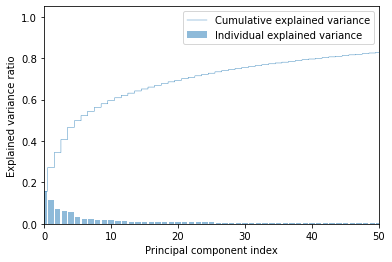

In [11]:
pca = PCA()
pca.fit_transform(X_train_imputed)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance', linewidth=0.4)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.xlim(0, 50)
plt.show()

In [12]:
pca = PCA(n_components=0.97, svd_solver='full')
X_pca = pca.fit_transform(X_train_imputed)
X_test_pca = pca.transform(X_test_imputed)
print(X_pca.shape)
print(X_test_pca.shape)

X_pca=pd.DataFrame(X_pca)
X_test_pca=pd.DataFrame(X_test_pca)

(5380, 162)
(4403, 162)


## Model

#### CatBoostRegressor

In [49]:
model_cat = CatBoostRegressor(verbose = False).fit(X_train_mars, y_train_log)

In [53]:
bagged_model = BaggingRegressor(base_estimator=CatBoostRegressor(), n_estimators=20, random_state=1,
                        n_jobs=-1).fit(X_train_mars, y_train_log)

Learning rate set to 0.053413
0:	learn: 0.9880200	total: 1.08s	remaining: 17m 59s
1:	learn: 0.9738572	total: 1.96s	remaining: 16m 16s
2:	learn: 0.9604615	total: 2.3s	remaining: 12m 43s
3:	learn: 0.9462118	total: 2.58s	remaining: 10m 41s
4:	learn: 0.9337550	total: 2.83s	remaining: 9m 23s
5:	learn: 0.9221765	total: 3.02s	remaining: 8m 19s
6:	learn: 0.9122460	total: 3.13s	remaining: 7m 23s
7:	learn: 0.9029823	total: 3.29s	remaining: 6m 47s
8:	learn: 0.8932156	total: 3.61s	remaining: 6m 37s
9:	learn: 0.8837765	total: 4.12s	remaining: 6m 47s
10:	learn: 0.8739371	total: 4.82s	remaining: 7m 13s
11:	learn: 0.8665915	total: 5.02s	remaining: 6m 53s
12:	learn: 0.8584473	total: 5.2s	remaining: 6m 34s
13:	learn: 0.8506156	total: 5.4s	remaining: 6m 20s
14:	learn: 0.8441243	total: 5.57s	remaining: 6m 6s
15:	learn: 0.8371311	total: 5.71s	remaining: 5m 51s
16:	learn: 0.8317551	total: 5.86s	remaining: 5m 38s
17:	learn: 0.8254277	total: 6s	remaining: 5m 27s
18:	learn: 0.8186225	total: 6.14s	remaining: 5m

191:	learn: 0.5598302	total: 41s	remaining: 2m 52s
192:	learn: 0.5586631	total: 41.2s	remaining: 2m 52s
193:	learn: 0.5572899	total: 41.4s	remaining: 2m 51s
194:	learn: 0.5561829	total: 41.5s	remaining: 2m 51s
195:	learn: 0.5550353	total: 41.7s	remaining: 2m 51s
196:	learn: 0.5540586	total: 41.9s	remaining: 2m 50s
197:	learn: 0.5527916	total: 42.1s	remaining: 2m 50s
198:	learn: 0.5517424	total: 42.2s	remaining: 2m 50s
199:	learn: 0.5508266	total: 42.4s	remaining: 2m 49s
200:	learn: 0.5497639	total: 42.6s	remaining: 2m 49s
201:	learn: 0.5487642	total: 42.8s	remaining: 2m 49s
202:	learn: 0.5475135	total: 43s	remaining: 2m 48s
203:	learn: 0.5465455	total: 43.2s	remaining: 2m 48s
204:	learn: 0.5457268	total: 43.3s	remaining: 2m 48s
205:	learn: 0.5445594	total: 43.5s	remaining: 2m 47s
206:	learn: 0.5436136	total: 43.7s	remaining: 2m 47s
207:	learn: 0.5425528	total: 43.9s	remaining: 2m 47s
208:	learn: 0.5411274	total: 44.1s	remaining: 2m 46s
209:	learn: 0.5399923	total: 44.3s	remaining: 2m 4

535:	learn: 0.3240204	total: 1m 58s	remaining: 1m 42s
536:	learn: 0.3233830	total: 1m 59s	remaining: 1m 42s
537:	learn: 0.3230344	total: 1m 59s	remaining: 1m 42s
538:	learn: 0.3226476	total: 1m 59s	remaining: 1m 42s
539:	learn: 0.3225975	total: 1m 59s	remaining: 1m 42s
540:	learn: 0.3222804	total: 2m	remaining: 1m 41s
541:	learn: 0.3217125	total: 2m	remaining: 1m 41s
542:	learn: 0.3211540	total: 2m	remaining: 1m 41s
543:	learn: 0.3207478	total: 2m	remaining: 1m 41s
544:	learn: 0.3203187	total: 2m 1s	remaining: 1m 41s
545:	learn: 0.3199747	total: 2m 1s	remaining: 1m 40s
546:	learn: 0.3196483	total: 2m 1s	remaining: 1m 40s
547:	learn: 0.3192105	total: 2m 1s	remaining: 1m 40s
548:	learn: 0.3187154	total: 2m 1s	remaining: 1m 40s
549:	learn: 0.3183685	total: 2m 2s	remaining: 1m 39s
550:	learn: 0.3179568	total: 2m 2s	remaining: 1m 39s
551:	learn: 0.3173478	total: 2m 2s	remaining: 1m 39s
552:	learn: 0.3169011	total: 2m 2s	remaining: 1m 39s
553:	learn: 0.3165634	total: 2m 3s	remaining: 1m 39s


760:	learn: 0.2468525	total: 2m 49s	remaining: 53.4s
761:	learn: 0.2466233	total: 2m 50s	remaining: 53.2s
762:	learn: 0.2463665	total: 2m 50s	remaining: 52.9s
763:	learn: 0.2460679	total: 2m 50s	remaining: 52.7s
764:	learn: 0.2458314	total: 2m 50s	remaining: 52.5s
765:	learn: 0.2455448	total: 2m 51s	remaining: 52.3s
766:	learn: 0.2452724	total: 2m 51s	remaining: 52s
767:	learn: 0.2451563	total: 2m 51s	remaining: 51.8s
768:	learn: 0.2448908	total: 2m 51s	remaining: 51.6s
769:	learn: 0.2445614	total: 2m 51s	remaining: 51.3s
770:	learn: 0.2442457	total: 2m 52s	remaining: 51.1s
771:	learn: 0.2440231	total: 2m 52s	remaining: 50.9s
772:	learn: 0.2438148	total: 2m 52s	remaining: 50.7s
773:	learn: 0.2434686	total: 2m 52s	remaining: 50.5s
774:	learn: 0.2432277	total: 2m 52s	remaining: 50.2s
775:	learn: 0.2428486	total: 2m 53s	remaining: 50s
776:	learn: 0.2424997	total: 2m 53s	remaining: 49.8s
777:	learn: 0.2421677	total: 2m 53s	remaining: 49.6s
778:	learn: 0.2418559	total: 2m 53s	remaining: 49.

Learning rate set to 0.053413
0:	learn: 0.9781461	total: 1.08s	remaining: 18m 2s
1:	learn: 0.9630454	total: 1.85s	remaining: 15m 22s
2:	learn: 0.9501776	total: 2.28s	remaining: 12m 36s
3:	learn: 0.9368778	total: 2.5s	remaining: 10m 23s
4:	learn: 0.9242238	total: 2.73s	remaining: 9m 3s
5:	learn: 0.9127278	total: 2.99s	remaining: 8m 15s
6:	learn: 0.9020053	total: 3.17s	remaining: 7m 29s
7:	learn: 0.8924440	total: 3.44s	remaining: 7m 6s
8:	learn: 0.8823166	total: 3.74s	remaining: 6m 51s
9:	learn: 0.8736710	total: 4.21s	remaining: 6m 56s
10:	learn: 0.8648215	total: 4.41s	remaining: 6m 36s
11:	learn: 0.8570284	total: 4.52s	remaining: 6m 12s
12:	learn: 0.8490798	total: 4.72s	remaining: 5m 58s
13:	learn: 0.8430207	total: 5s	remaining: 5m 52s
14:	learn: 0.8364683	total: 5.21s	remaining: 5m 42s
15:	learn: 0.8299973	total: 5.39s	remaining: 5m 31s
16:	learn: 0.8236143	total: 5.56s	remaining: 5m 21s
17:	learn: 0.8172330	total: 5.77s	remaining: 5m 14s
18:	learn: 0.8108834	total: 5.89s	remaining: 5m

141:	learn: 0.6087808	total: 31s	remaining: 3m 7s
142:	learn: 0.6077941	total: 31.2s	remaining: 3m 7s
143:	learn: 0.6069734	total: 31.4s	remaining: 3m 6s
144:	learn: 0.6062766	total: 31.6s	remaining: 3m 6s
145:	learn: 0.6054264	total: 31.8s	remaining: 3m 6s
146:	learn: 0.6043868	total: 31.9s	remaining: 3m 5s
147:	learn: 0.6031686	total: 32.2s	remaining: 3m 5s
148:	learn: 0.6018581	total: 32.3s	remaining: 3m 4s
149:	learn: 0.6010776	total: 32.5s	remaining: 3m 4s
150:	learn: 0.6002464	total: 32.7s	remaining: 3m 3s
151:	learn: 0.5993654	total: 32.9s	remaining: 3m 3s
152:	learn: 0.5987527	total: 33.1s	remaining: 3m 2s
153:	learn: 0.5976066	total: 33.3s	remaining: 3m 2s
154:	learn: 0.5963811	total: 33.5s	remaining: 3m 2s
155:	learn: 0.5955449	total: 33.7s	remaining: 3m 2s
156:	learn: 0.5944643	total: 33.8s	remaining: 3m 1s
157:	learn: 0.5935979	total: 34.1s	remaining: 3m 1s
158:	learn: 0.5923320	total: 34.3s	remaining: 3m 1s
159:	learn: 0.5913262	total: 34.5s	remaining: 3m 1s
160:	learn: 0.

Learning rate set to 0.053413
0:	learn: 0.9780160	total: 914ms	remaining: 15m 13s
1:	learn: 0.9632959	total: 1.57s	remaining: 13m 4s
2:	learn: 0.9484567	total: 2.27s	remaining: 12m 33s
3:	learn: 0.9342881	total: 2.49s	remaining: 10m 20s
4:	learn: 0.9217284	total: 2.76s	remaining: 9m 10s
5:	learn: 0.9107818	total: 2.97s	remaining: 8m 12s
6:	learn: 0.9002009	total: 3.17s	remaining: 7m 30s
7:	learn: 0.8905773	total: 3.34s	remaining: 6m 54s
8:	learn: 0.8808551	total: 3.62s	remaining: 6m 38s
9:	learn: 0.8711484	total: 4.57s	remaining: 7m 32s
10:	learn: 0.8623798	total: 4.92s	remaining: 7m 22s
11:	learn: 0.8542759	total: 5.16s	remaining: 7m 4s
12:	learn: 0.8457495	total: 5.36s	remaining: 6m 46s
13:	learn: 0.8400330	total: 5.54s	remaining: 6m 30s
14:	learn: 0.8341587	total: 5.71s	remaining: 6m 15s
15:	learn: 0.8278640	total: 5.86s	remaining: 6m
16:	learn: 0.8222046	total: 6.02s	remaining: 5m 47s
17:	learn: 0.8159834	total: 6.16s	remaining: 5m 36s
18:	learn: 0.8089670	total: 6.36s	remaining: 5

40:	learn: 0.7401322	total: 10.2s	remaining: 3m 59s
41:	learn: 0.7373247	total: 10.4s	remaining: 3m 57s
42:	learn: 0.7350922	total: 10.6s	remaining: 3m 56s
43:	learn: 0.7327233	total: 10.9s	remaining: 3m 56s
44:	learn: 0.7308933	total: 11.1s	remaining: 3m 55s
45:	learn: 0.7288018	total: 11.3s	remaining: 3m 54s
46:	learn: 0.7260927	total: 11.5s	remaining: 3m 53s
47:	learn: 0.7231931	total: 11.8s	remaining: 3m 53s
48:	learn: 0.7215767	total: 12s	remaining: 3m 53s
49:	learn: 0.7197592	total: 12.3s	remaining: 3m 52s
50:	learn: 0.7174615	total: 12.5s	remaining: 3m 51s
51:	learn: 0.7158585	total: 12.8s	remaining: 3m 53s
52:	learn: 0.7142979	total: 13s	remaining: 3m 51s
53:	learn: 0.7126599	total: 13.2s	remaining: 3m 52s
54:	learn: 0.7110964	total: 13.5s	remaining: 3m 52s
55:	learn: 0.7090846	total: 13.7s	remaining: 3m 51s
56:	learn: 0.7075663	total: 14s	remaining: 3m 51s
57:	learn: 0.7058762	total: 14.2s	remaining: 3m 50s
58:	learn: 0.7043276	total: 14.4s	remaining: 3m 49s
59:	learn: 0.70238

Learning rate set to 0.053413
0:	learn: 0.9808676	total: 589ms	remaining: 9m 48s
1:	learn: 0.9662437	total: 1.04s	remaining: 8m 40s
2:	learn: 0.9530490	total: 2.05s	remaining: 11m 20s
3:	learn: 0.9406813	total: 2.3s	remaining: 9m 32s
4:	learn: 0.9279799	total: 2.5s	remaining: 8m 18s
5:	learn: 0.9168576	total: 2.76s	remaining: 7m 37s
6:	learn: 0.9063320	total: 3s	remaining: 7m 5s
7:	learn: 0.8964510	total: 3.23s	remaining: 6m 40s
8:	learn: 0.8868971	total: 3.55s	remaining: 6m 31s
9:	learn: 0.8784253	total: 4.12s	remaining: 6m 47s
10:	learn: 0.8694439	total: 4.85s	remaining: 7m 15s
11:	learn: 0.8614466	total: 5.05s	remaining: 6m 56s
12:	learn: 0.8536285	total: 5.24s	remaining: 6m 38s
13:	learn: 0.8464311	total: 5.46s	remaining: 6m 24s
14:	learn: 0.8396320	total: 5.68s	remaining: 6m 12s
15:	learn: 0.8335355	total: 5.86s	remaining: 6m
16:	learn: 0.8281184	total: 6.04s	remaining: 5m 49s
17:	learn: 0.8221958	total: 6.17s	remaining: 5m 36s
18:	learn: 0.8162606	total: 6.36s	remaining: 5m 28s
1

238:	learn: 0.5060787	total: 55.7s	remaining: 2m 57s
239:	learn: 0.5051398	total: 55.9s	remaining: 2m 57s
240:	learn: 0.5044136	total: 56.1s	remaining: 2m 56s
241:	learn: 0.5035730	total: 56.4s	remaining: 2m 56s
242:	learn: 0.5025610	total: 56.5s	remaining: 2m 56s
243:	learn: 0.5017019	total: 56.8s	remaining: 2m 55s
244:	learn: 0.5005561	total: 57s	remaining: 2m 55s
245:	learn: 0.4993684	total: 57.2s	remaining: 2m 55s
246:	learn: 0.4983405	total: 57.4s	remaining: 2m 54s
247:	learn: 0.4976153	total: 57.5s	remaining: 2m 54s
248:	learn: 0.4966479	total: 57.7s	remaining: 2m 54s
249:	learn: 0.4955526	total: 58s	remaining: 2m 53s
250:	learn: 0.4943525	total: 58.2s	remaining: 2m 53s
251:	learn: 0.4933768	total: 58.5s	remaining: 2m 53s
252:	learn: 0.4922238	total: 58.6s	remaining: 2m 53s
253:	learn: 0.4914599	total: 58.8s	remaining: 2m 52s
254:	learn: 0.4899885	total: 59s	remaining: 2m 52s
255:	learn: 0.4893817	total: 59.3s	remaining: 2m 52s
256:	learn: 0.4880096	total: 59.5s	remaining: 2m 51s

238:	learn: 0.5114921	total: 55.4s	remaining: 2m 56s
239:	learn: 0.5105678	total: 55.7s	remaining: 2m 56s
240:	learn: 0.5099220	total: 55.9s	remaining: 2m 56s
241:	learn: 0.5091655	total: 56.1s	remaining: 2m 55s
242:	learn: 0.5084316	total: 56.3s	remaining: 2m 55s
243:	learn: 0.5077802	total: 56.5s	remaining: 2m 55s
244:	learn: 0.5067750	total: 56.8s	remaining: 2m 55s
245:	learn: 0.5059027	total: 57s	remaining: 2m 54s
246:	learn: 0.5051984	total: 57.3s	remaining: 2m 54s
247:	learn: 0.5044821	total: 57.5s	remaining: 2m 54s
248:	learn: 0.5034795	total: 57.7s	remaining: 2m 53s
249:	learn: 0.5025471	total: 57.9s	remaining: 2m 53s
250:	learn: 0.5016370	total: 58.1s	remaining: 2m 53s
251:	learn: 0.5007985	total: 58.3s	remaining: 2m 53s
252:	learn: 0.4998242	total: 58.5s	remaining: 2m 52s
253:	learn: 0.4990259	total: 58.8s	remaining: 2m 52s
254:	learn: 0.4982512	total: 59s	remaining: 2m 52s
255:	learn: 0.4976794	total: 59.2s	remaining: 2m 52s
256:	learn: 0.4968782	total: 59.5s	remaining: 2m 5

105:	learn: 0.6489374	total: 26.2s	remaining: 3m 40s
106:	learn: 0.6481575	total: 26.5s	remaining: 3m 40s
107:	learn: 0.6471022	total: 26.8s	remaining: 3m 41s
108:	learn: 0.6459097	total: 27.1s	remaining: 3m 41s
109:	learn: 0.6452639	total: 27.3s	remaining: 3m 40s
110:	learn: 0.6441223	total: 27.6s	remaining: 3m 40s
111:	learn: 0.6432156	total: 27.8s	remaining: 3m 40s
112:	learn: 0.6423606	total: 28s	remaining: 3m 40s
113:	learn: 0.6412644	total: 28.3s	remaining: 3m 39s
114:	learn: 0.6400492	total: 28.5s	remaining: 3m 39s
115:	learn: 0.6388621	total: 28.8s	remaining: 3m 39s
116:	learn: 0.6381269	total: 29s	remaining: 3m 38s
117:	learn: 0.6367430	total: 29.2s	remaining: 3m 38s
118:	learn: 0.6359138	total: 29.4s	remaining: 3m 37s
119:	learn: 0.6353755	total: 29.6s	remaining: 3m 37s
120:	learn: 0.6345681	total: 29.9s	remaining: 3m 36s
121:	learn: 0.6334359	total: 30.1s	remaining: 3m 36s
122:	learn: 0.6326143	total: 30.3s	remaining: 3m 36s
123:	learn: 0.6316552	total: 30.6s	remaining: 3m 3

238:	learn: 0.5162349	total: 55.5s	remaining: 2m 56s
239:	learn: 0.5155355	total: 55.8s	remaining: 2m 56s
240:	learn: 0.5146196	total: 56s	remaining: 2m 56s
241:	learn: 0.5138583	total: 56.2s	remaining: 2m 56s
242:	learn: 0.5130529	total: 56.4s	remaining: 2m 55s
243:	learn: 0.5124092	total: 56.6s	remaining: 2m 55s
244:	learn: 0.5113510	total: 56.8s	remaining: 2m 55s
245:	learn: 0.5105658	total: 57s	remaining: 2m 54s
246:	learn: 0.5093532	total: 57.2s	remaining: 2m 54s
247:	learn: 0.5083156	total: 57.4s	remaining: 2m 54s
248:	learn: 0.5076527	total: 57.6s	remaining: 2m 53s
249:	learn: 0.5068141	total: 57.9s	remaining: 2m 53s
250:	learn: 0.5061997	total: 58.1s	remaining: 2m 53s
251:	learn: 0.5053795	total: 58.4s	remaining: 2m 53s
252:	learn: 0.5046442	total: 58.6s	remaining: 2m 53s
253:	learn: 0.5034926	total: 58.8s	remaining: 2m 52s
254:	learn: 0.5025167	total: 59.1s	remaining: 2m 52s
255:	learn: 0.5019817	total: 59.3s	remaining: 2m 52s
256:	learn: 0.5011780	total: 59.5s	remaining: 2m 5

212:	learn: 0.5361590	total: 55.2s	remaining: 3m 24s
213:	learn: 0.5356116	total: 55.5s	remaining: 3m 23s
214:	learn: 0.5344857	total: 55.8s	remaining: 3m 23s
215:	learn: 0.5334215	total: 56s	remaining: 3m 23s
216:	learn: 0.5324672	total: 56.3s	remaining: 3m 23s
217:	learn: 0.5314158	total: 56.5s	remaining: 3m 22s
218:	learn: 0.5305685	total: 56.8s	remaining: 3m 22s
219:	learn: 0.5294499	total: 57s	remaining: 3m 22s
220:	learn: 0.5289402	total: 57.2s	remaining: 3m 21s
221:	learn: 0.5277369	total: 57.5s	remaining: 3m 21s
222:	learn: 0.5265361	total: 57.8s	remaining: 3m 21s
223:	learn: 0.5257972	total: 58.1s	remaining: 3m 21s
224:	learn: 0.5249344	total: 58.3s	remaining: 3m 20s
225:	learn: 0.5237625	total: 58.5s	remaining: 3m 20s
226:	learn: 0.5227729	total: 58.7s	remaining: 3m 19s
227:	learn: 0.5219197	total: 58.9s	remaining: 3m 19s
228:	learn: 0.5213319	total: 59.2s	remaining: 3m 19s
229:	learn: 0.5203532	total: 59.4s	remaining: 3m 18s
230:	learn: 0.5194179	total: 59.7s	remaining: 3m 1

238:	learn: 0.5139380	total: 55.8s	remaining: 2m 57s
239:	learn: 0.5128700	total: 56.1s	remaining: 2m 57s
240:	learn: 0.5117016	total: 56.3s	remaining: 2m 57s
241:	learn: 0.5107535	total: 56.5s	remaining: 2m 57s
242:	learn: 0.5099158	total: 56.7s	remaining: 2m 56s
243:	learn: 0.5088472	total: 56.9s	remaining: 2m 56s
244:	learn: 0.5079750	total: 57.2s	remaining: 2m 56s
245:	learn: 0.5070913	total: 57.4s	remaining: 2m 55s
246:	learn: 0.5063321	total: 57.6s	remaining: 2m 55s
247:	learn: 0.5053942	total: 57.8s	remaining: 2m 55s
248:	learn: 0.5039777	total: 58s	remaining: 2m 54s
249:	learn: 0.5030912	total: 58.2s	remaining: 2m 54s
250:	learn: 0.5021256	total: 58.4s	remaining: 2m 54s
251:	learn: 0.5014294	total: 58.6s	remaining: 2m 53s
252:	learn: 0.5003363	total: 58.8s	remaining: 2m 53s
253:	learn: 0.4996019	total: 59s	remaining: 2m 53s
254:	learn: 0.4989042	total: 59.3s	remaining: 2m 53s
255:	learn: 0.4980983	total: 59.5s	remaining: 2m 52s
256:	learn: 0.4973246	total: 59.7s	remaining: 2m 5

238:	learn: 0.5132469	total: 56.3s	remaining: 2m 59s
239:	learn: 0.5119856	total: 56.6s	remaining: 2m 59s
240:	learn: 0.5111377	total: 56.8s	remaining: 2m 58s
241:	learn: 0.5109021	total: 57.1s	remaining: 2m 58s
242:	learn: 0.5099250	total: 57.3s	remaining: 2m 58s
243:	learn: 0.5088402	total: 57.5s	remaining: 2m 58s
244:	learn: 0.5084670	total: 57.7s	remaining: 2m 57s
245:	learn: 0.5076173	total: 57.9s	remaining: 2m 57s
246:	learn: 0.5066436	total: 58.1s	remaining: 2m 57s
247:	learn: 0.5059776	total: 58.3s	remaining: 2m 56s
248:	learn: 0.5051902	total: 58.5s	remaining: 2m 56s
249:	learn: 0.5041274	total: 58.8s	remaining: 2m 56s
250:	learn: 0.5028873	total: 59s	remaining: 2m 56s
251:	learn: 0.5026637	total: 59.1s	remaining: 2m 55s
252:	learn: 0.5014751	total: 59.3s	remaining: 2m 55s
253:	learn: 0.5005308	total: 59.5s	remaining: 2m 54s
254:	learn: 0.4997477	total: 59.8s	remaining: 2m 54s
255:	learn: 0.4986448	total: 1m	remaining: 2m 54s
256:	learn: 0.4978011	total: 1m	remaining: 2m 54s
2

238:	learn: 0.4988079	total: 56.2s	remaining: 2m 59s
239:	learn: 0.4982385	total: 56.5s	remaining: 2m 58s
240:	learn: 0.4972516	total: 56.6s	remaining: 2m 58s
241:	learn: 0.4964099	total: 56.8s	remaining: 2m 57s
242:	learn: 0.4956419	total: 57.1s	remaining: 2m 57s
243:	learn: 0.4940549	total: 57.3s	remaining: 2m 57s
244:	learn: 0.4929429	total: 57.6s	remaining: 2m 57s
245:	learn: 0.4919704	total: 57.7s	remaining: 2m 56s
246:	learn: 0.4915998	total: 57.9s	remaining: 2m 56s
247:	learn: 0.4906345	total: 58.2s	remaining: 2m 56s
248:	learn: 0.4894162	total: 58.4s	remaining: 2m 56s
249:	learn: 0.4888995	total: 58.6s	remaining: 2m 55s
250:	learn: 0.4880425	total: 58.8s	remaining: 2m 55s
251:	learn: 0.4876304	total: 59s	remaining: 2m 55s
252:	learn: 0.4871886	total: 59.2s	remaining: 2m 54s
253:	learn: 0.4863797	total: 59.4s	remaining: 2m 54s
254:	learn: 0.4852845	total: 59.6s	remaining: 2m 54s
255:	learn: 0.4843134	total: 59.8s	remaining: 2m 53s
256:	learn: 0.4834201	total: 1m	remaining: 2m 53

143:	learn: 0.6050551	total: 38.8s	remaining: 3m 50s
144:	learn: 0.6037600	total: 39s	remaining: 3m 49s
145:	learn: 0.6027779	total: 39.3s	remaining: 3m 49s
146:	learn: 0.6020191	total: 39.4s	remaining: 3m 48s
147:	learn: 0.6015159	total: 39.7s	remaining: 3m 48s
148:	learn: 0.6007587	total: 40s	remaining: 3m 48s
149:	learn: 0.6000129	total: 40.3s	remaining: 3m 48s
150:	learn: 0.5991700	total: 40.6s	remaining: 3m 48s
151:	learn: 0.5981808	total: 40.8s	remaining: 3m 47s
152:	learn: 0.5974650	total: 41.1s	remaining: 3m 47s
153:	learn: 0.5958063	total: 41.4s	remaining: 3m 47s
154:	learn: 0.5950335	total: 41.7s	remaining: 3m 47s
155:	learn: 0.5939219	total: 41.9s	remaining: 3m 46s
156:	learn: 0.5930398	total: 42.2s	remaining: 3m 46s
157:	learn: 0.5921951	total: 42.5s	remaining: 3m 46s
158:	learn: 0.5912476	total: 42.7s	remaining: 3m 45s
159:	learn: 0.5905731	total: 43s	remaining: 3m 45s
160:	learn: 0.5895043	total: 43.2s	remaining: 3m 45s
161:	learn: 0.5885167	total: 43.5s	remaining: 3m 45s

237:	learn: 0.5134627	total: 1m 1s	remaining: 3m 15s
238:	learn: 0.5124917	total: 1m 1s	remaining: 3m 15s
239:	learn: 0.5117581	total: 1m 1s	remaining: 3m 15s
240:	learn: 0.5109178	total: 1m 2s	remaining: 3m 15s
241:	learn: 0.5099218	total: 1m 2s	remaining: 3m 15s
242:	learn: 0.5088155	total: 1m 2s	remaining: 3m 14s
243:	learn: 0.5079617	total: 1m 2s	remaining: 3m 14s
244:	learn: 0.5075447	total: 1m 3s	remaining: 3m 14s
245:	learn: 0.5069435	total: 1m 3s	remaining: 3m 14s
246:	learn: 0.5059078	total: 1m 3s	remaining: 3m 13s
247:	learn: 0.5051714	total: 1m 3s	remaining: 3m 13s
248:	learn: 0.5043724	total: 1m 4s	remaining: 3m 13s
249:	learn: 0.5041255	total: 1m 4s	remaining: 3m 13s
250:	learn: 0.5032614	total: 1m 4s	remaining: 3m 13s
251:	learn: 0.5023269	total: 1m 5s	remaining: 3m 13s
252:	learn: 0.5014408	total: 1m 5s	remaining: 3m 13s
253:	learn: 0.5005689	total: 1m 5s	remaining: 3m 13s
254:	learn: 0.5001391	total: 1m 6s	remaining: 3m 13s
255:	learn: 0.4995324	total: 1m 6s	remaining: 

468:	learn: 0.3556128	total: 2m	remaining: 2m 16s
469:	learn: 0.3552050	total: 2m	remaining: 2m 16s
470:	learn: 0.3548919	total: 2m	remaining: 2m 15s
471:	learn: 0.3543676	total: 2m 1s	remaining: 2m 15s
472:	learn: 0.3538095	total: 2m 1s	remaining: 2m 15s
473:	learn: 0.3533439	total: 2m 1s	remaining: 2m 14s
474:	learn: 0.3528682	total: 2m 1s	remaining: 2m 14s
475:	learn: 0.3526780	total: 2m 2s	remaining: 2m 14s
476:	learn: 0.3519008	total: 2m 2s	remaining: 2m 14s
477:	learn: 0.3513262	total: 2m 2s	remaining: 2m 13s
478:	learn: 0.3506347	total: 2m 2s	remaining: 2m 13s
479:	learn: 0.3502873	total: 2m 3s	remaining: 2m 13s
480:	learn: 0.3496080	total: 2m 3s	remaining: 2m 13s
481:	learn: 0.3492287	total: 2m 3s	remaining: 2m 12s
482:	learn: 0.3488558	total: 2m 3s	remaining: 2m 12s
483:	learn: 0.3483802	total: 2m 4s	remaining: 2m 12s
484:	learn: 0.3479101	total: 2m 4s	remaining: 2m 11s
485:	learn: 0.3474449	total: 2m 4s	remaining: 2m 11s
486:	learn: 0.3470856	total: 2m 4s	remaining: 2m 11s
48

469:	learn: 0.3669494	total: 1m 59s	remaining: 2m 14s
470:	learn: 0.3663902	total: 1m 59s	remaining: 2m 14s
471:	learn: 0.3660860	total: 2m	remaining: 2m 14s
472:	learn: 0.3657085	total: 2m	remaining: 2m 14s
473:	learn: 0.3652209	total: 2m	remaining: 2m 13s
474:	learn: 0.3647378	total: 2m	remaining: 2m 13s
475:	learn: 0.3642060	total: 2m 1s	remaining: 2m 13s
476:	learn: 0.3637085	total: 2m 1s	remaining: 2m 13s
477:	learn: 0.3632346	total: 2m 1s	remaining: 2m 12s
478:	learn: 0.3628267	total: 2m 1s	remaining: 2m 12s
479:	learn: 0.3624289	total: 2m 2s	remaining: 2m 12s
480:	learn: 0.3620606	total: 2m 2s	remaining: 2m 12s
481:	learn: 0.3614845	total: 2m 2s	remaining: 2m 11s
482:	learn: 0.3611331	total: 2m 2s	remaining: 2m 11s
483:	learn: 0.3605403	total: 2m 3s	remaining: 2m 11s
484:	learn: 0.3600759	total: 2m 3s	remaining: 2m 11s
485:	learn: 0.3595665	total: 2m 3s	remaining: 2m 10s
486:	learn: 0.3592322	total: 2m 3s	remaining: 2m 10s
487:	learn: 0.3591388	total: 2m 4s	remaining: 2m 10s
488

469:	learn: 0.3564758	total: 2m	remaining: 2m 15s
470:	learn: 0.3560422	total: 2m	remaining: 2m 15s
471:	learn: 0.3556494	total: 2m	remaining: 2m 14s
472:	learn: 0.3551058	total: 2m	remaining: 2m 14s
473:	learn: 0.3546376	total: 2m 1s	remaining: 2m 14s
474:	learn: 0.3540658	total: 2m 1s	remaining: 2m 14s
475:	learn: 0.3534277	total: 2m 1s	remaining: 2m 13s
476:	learn: 0.3528089	total: 2m 1s	remaining: 2m 13s
477:	learn: 0.3523889	total: 2m 2s	remaining: 2m 13s
478:	learn: 0.3520126	total: 2m 2s	remaining: 2m 12s
479:	learn: 0.3516412	total: 2m 2s	remaining: 2m 12s
480:	learn: 0.3510352	total: 2m 2s	remaining: 2m 12s
481:	learn: 0.3506872	total: 2m 2s	remaining: 2m 12s
482:	learn: 0.3501455	total: 2m 3s	remaining: 2m 11s
483:	learn: 0.3496184	total: 2m 3s	remaining: 2m 11s
484:	learn: 0.3491428	total: 2m 3s	remaining: 2m 11s
485:	learn: 0.3485666	total: 2m 3s	remaining: 2m 11s
486:	learn: 0.3480655	total: 2m 4s	remaining: 2m 10s
487:	learn: 0.3474860	total: 2m 4s	remaining: 2m 10s
488:	

655:	learn: 0.2743482	total: 2m 3s	remaining: 1m 4s
656:	learn: 0.2741189	total: 2m 3s	remaining: 1m 4s
657:	learn: 0.2736041	total: 2m 4s	remaining: 1m 4s
658:	learn: 0.2732677	total: 2m 4s	remaining: 1m 4s
659:	learn: 0.2727844	total: 2m 4s	remaining: 1m 4s
660:	learn: 0.2723934	total: 2m 4s	remaining: 1m 3s
661:	learn: 0.2719994	total: 2m 4s	remaining: 1m 3s
662:	learn: 0.2717546	total: 2m 4s	remaining: 1m 3s
663:	learn: 0.2712807	total: 2m 4s	remaining: 1m 3s
664:	learn: 0.2709807	total: 2m 4s	remaining: 1m 2s
665:	learn: 0.2705969	total: 2m 5s	remaining: 1m 2s
666:	learn: 0.2702513	total: 2m 5s	remaining: 1m 2s
667:	learn: 0.2698554	total: 2m 5s	remaining: 1m 2s
668:	learn: 0.2694542	total: 2m 5s	remaining: 1m 2s
669:	learn: 0.2691026	total: 2m 5s	remaining: 1m 1s
670:	learn: 0.2687414	total: 2m 5s	remaining: 1m 1s
671:	learn: 0.2684730	total: 2m 6s	remaining: 1m 1s
672:	learn: 0.2681280	total: 2m 6s	remaining: 1m 1s
673:	learn: 0.2676947	total: 2m 6s	remaining: 1m 1s
674:	learn: 

468:	learn: 0.3493606	total: 2m	remaining: 2m 16s
469:	learn: 0.3487010	total: 2m	remaining: 2m 16s
470:	learn: 0.3483335	total: 2m 1s	remaining: 2m 16s
471:	learn: 0.3478971	total: 2m 1s	remaining: 2m 15s
472:	learn: 0.3474047	total: 2m 1s	remaining: 2m 15s
473:	learn: 0.3468631	total: 2m 1s	remaining: 2m 15s
474:	learn: 0.3462797	total: 2m 2s	remaining: 2m 14s
475:	learn: 0.3457315	total: 2m 2s	remaining: 2m 14s
476:	learn: 0.3451105	total: 2m 2s	remaining: 2m 14s
477:	learn: 0.3446491	total: 2m 2s	remaining: 2m 14s
478:	learn: 0.3442902	total: 2m 3s	remaining: 2m 13s
479:	learn: 0.3438468	total: 2m 3s	remaining: 2m 13s
480:	learn: 0.3433397	total: 2m 3s	remaining: 2m 13s
481:	learn: 0.3425570	total: 2m 3s	remaining: 2m 13s
482:	learn: 0.3418905	total: 2m 4s	remaining: 2m 12s
483:	learn: 0.3414834	total: 2m 4s	remaining: 2m 12s
484:	learn: 0.3409521	total: 2m 4s	remaining: 2m 12s
485:	learn: 0.3406570	total: 2m 4s	remaining: 2m 12s
486:	learn: 0.3401308	total: 2m 5s	remaining: 2m 11s

467:	learn: 0.3642725	total: 2m 36s	remaining: 2m 59s
468:	learn: 0.3637530	total: 2m 37s	remaining: 2m 58s
469:	learn: 0.3633849	total: 2m 37s	remaining: 2m 58s
470:	learn: 0.3629057	total: 2m 38s	remaining: 2m 58s
471:	learn: 0.3625386	total: 2m 38s	remaining: 2m 57s
472:	learn: 0.3621828	total: 2m 38s	remaining: 2m 57s
473:	learn: 0.3617474	total: 2m 38s	remaining: 2m 56s
474:	learn: 0.3610397	total: 2m 38s	remaining: 2m 56s
475:	learn: 0.3604972	total: 2m 39s	remaining: 2m 56s
476:	learn: 0.3598572	total: 2m 40s	remaining: 2m 56s
477:	learn: 0.3593232	total: 2m 40s	remaining: 2m 56s
478:	learn: 0.3589778	total: 2m 41s	remaining: 2m 56s
479:	learn: 0.3583364	total: 2m 41s	remaining: 2m 55s
480:	learn: 0.3578611	total: 2m 42s	remaining: 2m 56s
481:	learn: 0.3574897	total: 2m 42s	remaining: 2m 55s
482:	learn: 0.3569672	total: 2m 43s	remaining: 2m 55s
483:	learn: 0.3563220	total: 2m 43s	remaining: 2m 55s
484:	learn: 0.3558380	total: 2m 44s	remaining: 2m 55s
485:	learn: 0.3554798	total:

In [54]:
y_pred = np.exp(bagged_model.predict(X_train_mars))
intercept = np.mean(y_train-y_pred)
predicted_3 = np.exp(bagged_model.predict(X_test_mars))+intercept

In [36]:
y_pred = np.exp(bagged_model.predict(X_train_mars))
intercept = np.mean(y_train-y_pred)
predicted_2 = np.exp(bagged_model.predict(X_test_mars))+intercept

In [50]:
y_pred = np.exp(model_cat.predict(X_train_mars))
intercept = np.mean(y_train-y_pred)
predicted_1 = np.exp(model_cat.predict(X_test_mars))+intercept

#### MARS

In [85]:
cv_scores = []
degrees = range(1, 5)

for d in degrees:
    model = Earth(max_terms=500, max_degree=d)
    scores = cross_val_score(model, X_train_imputed, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(np.mean(np.sqrt(-scores)))
    
# Find the best degree
optimal_degree = degrees[np.argmin(cv_scores)] # argmin
optimal_degree

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and 

1

In [13]:
mars_model = Earth(feature_importance_type='rss', max_degree=1)
mars_model.fit(X_train_imputed, y_train)

feature_df = pd.DataFrame({'Predictors':X_train_imputed.columns, 'Importance': mars_model.feature_importances_}).sort_values(by='Importance', ascending=False)[0:25]
feature_df

In [89]:
y_pred = mars_model.predict(X_test_imputed)

In [92]:
bagged_model = BaggingRegressor(base_estimator=mars_model, n_estimators=20, random_state=1,n_jobs=-1).fit(X_train_imputed, y_train)

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and 

In [98]:
bagged_model2 = BaggingRegressor(base_estimator=mars_model, n_estimators=50, random_state=1,n_jobs=-1).fit(X_train_imputed, y_train)

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
T

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precisi

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and 

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N

In [14]:
bagged_model3 = BaggingRegressor(base_estimator=mars_model, n_estimators=50, random_state=1,n_jobs=-1).fit(X_pca, y_train)

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and 

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N

In [15]:
y_pred_bagged3 = bagged_model3.predict(X_test_pca)

In [99]:
y_pred_bagged2 = bagged_model2.predict(X_test_imputed)

In [93]:
y_pred_bagged = bagged_model.predict(X_test_imputed)

#### Random Forest

In [ ]:
# also try PCA then mars

In [76]:
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train_imputed, y_train)

importances = rf.feature_importances_

# Create a DataFrame to store feature importances
feature_importances = pd.DataFrame({'Feature': X_train_imputed.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

In [83]:
# Select a threshold for dropping predictors (e.g., keep the top 100 predictors)
threshold = 100
selected_predictors = feature_importances.head(threshold)['Feature'].tolist()

# Filter the predictors based on the selected features
X_train_reduced = X_train_imputed[selected_predictors]
X_test_reduced = X_test_imputed[selected_predictors]

# Retrain the model on the reduced set of predictors
rf_reduced = RandomForestRegressor()
rf_reduced.fit(X_train_reduced, y_train)

# Make predictions on the test set
y_pred = rf_reduced.predict(X_test_reduced)

#### Lasso

In [60]:
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(X_pca, y_train)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

0.05

In [62]:
#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(X_pca, y_train)
y_pred = lasso.predict(X_test_pca)

In [65]:
bagged_model = BaggingRegressor(base_estimator=lasso, n_estimators=20, random_state=1,n_jobs=-1).fit(X_pca, y_train)

In [69]:
y_pred_bagged = bagged_model.predict(X_test_pca)

#### XGBoost

In [27]:
xgb = XGBRegressor(random_state=0)

# Coarse grid search
param_grid = {'max_depth':[4,6,8],
              'n_estimators':[500,1000,1500,2000], 
              'learning_rate':[0.01,0.1,0.5],
              'reg_lambda':[0,1,10],
              'gamma':[0,10],
              'subsample':[0.1,0.3,0.5]
             }

cv = KFold(n_splits=2, shuffle=True, random_state=1)
grid = RandomizedSearchCV(xgb, param_grid, n_jobs=-1,verbose=1,cv=cv, scoring='neg_mean_absolute_error')
grid.fit(X_pca, y_train)

print(grid.best_score_, grid.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
-5.572655244143922 {'subsample': 0.5, 'reg_lambda': 10, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0}


In [29]:
xgb = XGBRegressor(random_state=0)

# Coarse grid search
param_grid = {'max_depth':[4,5,6,8],
              'n_estimators':[100,200,300,400,500], 
              'learning_rate':[0.01,0.03,0.1],
              'reg_lambda':[8,9,10],
              'gamma':[0,1,2],
              'subsample':[0.4,0.45,0.5]
             }

cv = KFold(n_splits=2, shuffle=True, random_state=1)
grid = RandomizedSearchCV(xgb, param_grid, n_jobs=-1,verbose=1,cv=cv, scoring='neg_mean_absolute_error')
grid.fit(X_pca, y_train)

print(grid.best_score_, grid.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
-5.3929182449238 {'subsample': 0.4, 'reg_lambda': 9, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 1}


In [29]:
xgb = XGBRegressor(random_state=0)

# Coarse grid search
param_grid = {'max_depth':[4,5,6,8],
              'n_estimators':[100,200,300,400,500], 
              'learning_rate':[0.01,0.03,0.1],
              'reg_lambda':[8,9,10],
              'gamma':[0,1,2],
              'subsample':[0.4,0.45,0.5]
             }

cv = KFold(n_splits=2, shuffle=True, random_state=1)
grid = RandomizedSearchCV(xgb, param_grid, n_jobs=-1,verbose=1,cv=cv, scoring='neg_mean_absolute_error')
grid.fit(X_pca, y_train)

print(grid.best_score_, grid.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
-5.3929182449238 {'subsample': 0.4, 'reg_lambda': 9, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 1}


In [56]:
xgb_tuned = XGBRegressor(random_state=1,
                         max_depth=8,
                         n_estimators=500,
                         learning_rate=0.01,
                         reg_lambda=9,
                         gamma=1,
                         subsample=0.4)

xgb_tuned.fit(X_pca, y_train)
y_pred = xgb_tuned.predict(X_test_pca)

## Predict

In [37]:
predictions = pd.DataFrame({"id":test.iloc[:, 0], "y":predicted_2})

# Clip the predicted y-values
predictions['y'] = predictions['y'].clip(lower=1, upper=100)
predictions

,id,y
0,5380,7.626657
1,5381,10.068025
2,5382,4.068146
3,5383,5.157224
4,5384,5.961296
...,...,...
4398,9778,5.388514
4399,9779,8.898245
4400,9780,11.570308
4401,9781,12.980668


In [55]:
predictions = pd.DataFrame({"id":test.iloc[:, 0], "y":predicted_3})

# Clip the predicted y-values
predictions['y'] = predictions['y'].clip(lower=1, upper=100)
predictions

,id,y
0,5380,5.489005
1,5381,7.741134
2,5382,4.548007
3,5383,7.421040
4,5384,4.441458
...,...,...
4398,9778,4.085363
4399,9779,9.050594
4400,9780,9.435867
4401,9781,9.340904


In [94]:
predictions = pd.DataFrame({"id":test.iloc[:, 0], "y":y_pred_bagged})
predictions

,id,y
0,5380,7.680311
1,5381,9.899379
2,5382,2.845986
3,5383,6.781913
4,5384,8.118438
...,...,...
4398,9778,7.686397
4399,9779,9.947544
4400,9780,12.928356
4401,9781,16.439196


In [16]:
predictions = pd.DataFrame({"id":test.iloc[:, 0], "y":y_pred_bagged3})
predictions

,id,y
0,5380,9.031142
1,5381,13.915071
2,5382,6.070101
3,5383,2.928970
4,5384,25.700963
...,...,...
4398,9778,-0.415455
4399,9779,10.483314
4400,9780,7.826417
4401,9781,14.317061


In [56]:
predictions.to_csv("regression_pred19.csv", index = False)

469:	learn: 0.3605373	total: 2m 2s	remaining: 2m 18s
470:	learn: 0.3600536	total: 2m 3s	remaining: 2m 18s
471:	learn: 0.3595572	total: 2m 3s	remaining: 2m 17s
472:	learn: 0.3591336	total: 2m 3s	remaining: 2m 17s
473:	learn: 0.3587236	total: 2m 3s	remaining: 2m 17s
474:	learn: 0.3579276	total: 2m 4s	remaining: 2m 17s
475:	learn: 0.3574728	total: 2m 4s	remaining: 2m 16s
476:	learn: 0.3574241	total: 2m 4s	remaining: 2m 16s
477:	learn: 0.3571021	total: 2m 4s	remaining: 2m 16s
478:	learn: 0.3566069	total: 2m 4s	remaining: 2m 15s
479:	learn: 0.3565578	total: 2m 5s	remaining: 2m 15s
480:	learn: 0.3560511	total: 2m 5s	remaining: 2m 15s
481:	learn: 0.3555886	total: 2m 5s	remaining: 2m 14s
482:	learn: 0.3551503	total: 2m 5s	remaining: 2m 14s
483:	learn: 0.3551089	total: 2m 6s	remaining: 2m 14s
484:	learn: 0.3546779	total: 2m 6s	remaining: 2m 14s
485:	learn: 0.3541922	total: 2m 6s	remaining: 2m 13s
486:	learn: 0.3536471	total: 2m 6s	remaining: 2m 13s
487:	learn: 0.3530476	total: 2m 7s	remaining: 

469:	learn: 0.3574424	total: 1m 59s	remaining: 2m 14s
470:	learn: 0.3570878	total: 2m	remaining: 2m 14s
471:	learn: 0.3565505	total: 2m	remaining: 2m 14s
472:	learn: 0.3561769	total: 2m	remaining: 2m 14s
473:	learn: 0.3556517	total: 2m	remaining: 2m 14s
474:	learn: 0.3549577	total: 2m 1s	remaining: 2m 13s
475:	learn: 0.3544767	total: 2m 1s	remaining: 2m 13s
476:	learn: 0.3540739	total: 2m 1s	remaining: 2m 13s
477:	learn: 0.3536341	total: 2m 1s	remaining: 2m 12s
478:	learn: 0.3531937	total: 2m 1s	remaining: 2m 12s
479:	learn: 0.3527054	total: 2m 2s	remaining: 2m 12s
480:	learn: 0.3520321	total: 2m 2s	remaining: 2m 11s
481:	learn: 0.3517235	total: 2m 2s	remaining: 2m 11s
482:	learn: 0.3511012	total: 2m 2s	remaining: 2m 11s
483:	learn: 0.3505970	total: 2m 2s	remaining: 2m 11s
484:	learn: 0.3503132	total: 2m 3s	remaining: 2m 10s
485:	learn: 0.3496906	total: 2m 3s	remaining: 2m 10s
486:	learn: 0.3492545	total: 2m 3s	remaining: 2m 10s
487:	learn: 0.3488202	total: 2m 3s	remaining: 2m 9s
488:	

702:	learn: 0.2652011	total: 2m 11s	remaining: 55.7s
703:	learn: 0.2648727	total: 2m 12s	remaining: 55.5s
704:	learn: 0.2645712	total: 2m 12s	remaining: 55.4s
705:	learn: 0.2642726	total: 2m 12s	remaining: 55.3s
706:	learn: 0.2639208	total: 2m 13s	remaining: 55.1s
707:	learn: 0.2635863	total: 2m 13s	remaining: 54.9s
708:	learn: 0.2632205	total: 2m 13s	remaining: 54.7s
709:	learn: 0.2629456	total: 2m 13s	remaining: 54.5s
710:	learn: 0.2624541	total: 2m 13s	remaining: 54.4s
711:	learn: 0.2620112	total: 2m 13s	remaining: 54.2s
712:	learn: 0.2616425	total: 2m 14s	remaining: 54.1s
713:	learn: 0.2616111	total: 2m 14s	remaining: 53.9s
714:	learn: 0.2612684	total: 2m 14s	remaining: 53.8s
715:	learn: 0.2608623	total: 2m 15s	remaining: 53.6s
716:	learn: 0.2605605	total: 2m 15s	remaining: 53.5s
717:	learn: 0.2602805	total: 2m 15s	remaining: 53.3s
718:	learn: 0.2599323	total: 2m 15s	remaining: 53.1s
719:	learn: 0.2596743	total: 2m 16s	remaining: 53s
720:	learn: 0.2594621	total: 2m 16s	remaining: 5

700:	learn: 0.2588851	total: 2m 12s	remaining: 56.5s
701:	learn: 0.2585663	total: 2m 12s	remaining: 56.3s
702:	learn: 0.2582187	total: 2m 12s	remaining: 56.1s
703:	learn: 0.2577193	total: 2m 13s	remaining: 55.9s
704:	learn: 0.2574168	total: 2m 13s	remaining: 55.7s
705:	learn: 0.2570791	total: 2m 13s	remaining: 55.6s
706:	learn: 0.2567671	total: 2m 13s	remaining: 55.4s
707:	learn: 0.2564449	total: 2m 13s	remaining: 55.2s
708:	learn: 0.2561821	total: 2m 14s	remaining: 55.1s
709:	learn: 0.2557628	total: 2m 14s	remaining: 54.9s
710:	learn: 0.2553952	total: 2m 14s	remaining: 54.7s
711:	learn: 0.2550175	total: 2m 15s	remaining: 54.6s
712:	learn: 0.2549623	total: 2m 15s	remaining: 54.5s
713:	learn: 0.2546556	total: 2m 15s	remaining: 54.3s
714:	learn: 0.2543241	total: 2m 15s	remaining: 54.1s
715:	learn: 0.2539787	total: 2m 15s	remaining: 53.9s
716:	learn: 0.2535793	total: 2m 16s	remaining: 53.8s
717:	learn: 0.2531896	total: 2m 16s	remaining: 53.5s
718:	learn: 0.2529100	total: 2m 16s	remaining:

701:	learn: 0.2751327	total: 2m 13s	remaining: 56.7s
702:	learn: 0.2747719	total: 2m 13s	remaining: 56.5s
703:	learn: 0.2743386	total: 2m 13s	remaining: 56.3s
704:	learn: 0.2739673	total: 2m 14s	remaining: 56.2s
705:	learn: 0.2736133	total: 2m 14s	remaining: 56s
706:	learn: 0.2732834	total: 2m 14s	remaining: 55.9s
707:	learn: 0.2732588	total: 2m 15s	remaining: 55.7s
708:	learn: 0.2729011	total: 2m 15s	remaining: 55.5s
709:	learn: 0.2725435	total: 2m 15s	remaining: 55.3s
710:	learn: 0.2721591	total: 2m 15s	remaining: 55.1s
711:	learn: 0.2719859	total: 2m 15s	remaining: 54.9s
712:	learn: 0.2715570	total: 2m 16s	remaining: 54.8s
713:	learn: 0.2712216	total: 2m 16s	remaining: 54.7s
714:	learn: 0.2709177	total: 2m 16s	remaining: 54.5s
715:	learn: 0.2705780	total: 2m 16s	remaining: 54.3s
716:	learn: 0.2702187	total: 2m 17s	remaining: 54.1s
717:	learn: 0.2699432	total: 2m 17s	remaining: 53.9s
718:	learn: 0.2696773	total: 2m 17s	remaining: 53.7s
719:	learn: 0.2694786	total: 2m 17s	remaining: 5

# Spacer

In [40]:
y_pred_bagged = bagged_model.predict(X_test_imputed)
y_pred_bagged.shape

(4403,)

In [39]:
bagged_model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=20, random_state=1,
                        n_jobs=-1).fit(X_train_imputed, y_train)

<AxesSubplot:xlabel='y', ylabel='Count'>

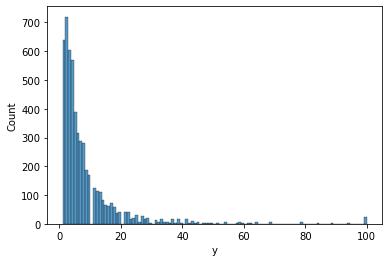

In [71]:
sns.histplot(train.y)

In [63]:
y_train = train.y
X_train = train.drop(['id', 'y'], axis=1)

X_test = test.drop('id', axis=1)

### Tune k

In [64]:
X_train = X_train.astype(float)

In [65]:
X_train.dtypes.value_counts()

float64    765
dtype: int64

In [67]:
cols = list(X_train.columns)

In [69]:
k_range = list(range(1, 21))
rf = RandomForestRegressor()
pipeline = Pipeline([('imputer', KNNImputer()),
                     ("rf", rf)])
param_grid = {'imputer__n_neighbors': k_range,
              'rf__n_estimators': [10, 50, 100],
              'rf__max_depth': [5, 10, 15]}

grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train_scaled, y_train)

KeyboardInterrupt: 

In [34]:
imputer = KNNImputer()

k_range = list(range(1, 21))
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler()), ('imputer', KNNImputer())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, cols)])

param_grid = {'preprocessor__num__imputer__n_neighbors': k_range}

grid = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

print('Best k:', grid.best_params_['preprocessor__num__imputer__n_neighbors'])


ValueError: Invalid parameter preprocessor for estimator LinearRegression(). Check the list of available parameters with `estimator.get_params().keys()`.

In [39]:
X_train_scaled2 = X_train_scaled.dropna()
X_train_scaled2.isna().sum()

x001    0
x002    0
x003    0
x004    0
x005    0
       ..
x761    0
x762    0
x763    0
x764    0
x765    0
Length: 765, dtype: int64

In [47]:
y_train2.isna().sum()

0

In [43]:
y_train2=y_train[X_train_scaled2.index]

In [44]:
imputer = KNNImputer()

k_range = list(range(1, 21))

param_grid = {'n_neighbors': k_range}

grid = GridSearchCV(imputer, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train_scaled2, y_train2)

print('Best k:', grid.best_params_['n_neighbors'])

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'KNNImputer' object has no attribute 'predict'

  warnings.warn(
/Users

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'KNNImputer' object has no attribute 'predict'

  warnings.warn(
/Users

/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'KNNImputer' object has no attribute 'predict'

  warnings.warn(
/Users

Best k: 1


/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/adazhong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'KNNImputer' object has no attribute 'predict'

  warnings.warn(
/Users

### Scale data and impute missing values with KNN

In [20]:
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

X_train_scaled.columns = X_train.columns

# imputer = KNNImputer(n_neighbors=1, weights="uniform")
# X_train_imputed = imputer.fit_transform(X_train_scaled) 